In [ ]:
import networkx as nx
import numpy as np
import random as random
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Khoi tao quan the dau tien
def initialize_population(G, population_size):
    N = G.shape[0]
    individuals = []
    np.random.seed(123)
    for i in range(population_size):
        individual =np.random.randint(N,size=N)
        for j in range(N):
            if(G[j,individual[j]] == 0):
                neighbors = np.array(np.where(G[j,:] >= 1))
                n_neighbor = len(neighbors[0])
                neighbors = neighbors.reshape(n_neighbor)
                i_n = np.random.randint(n_neighbor)
                individual[j] = neighbors[i_n]

        individuals.append(individual)
    return np.array(individuals)

In [ ]:
# Decode
def decode(G,chrom):
  cc=0
  clusterAssignment=[None]*len(chrom)
  previous=[None]*len(chrom)
  for i in range(len(chrom)):
    ctr=0
    if clusterAssignment[i]==None:
      clusterAssignment[i]=cc
      neighbor=chrom[i]
      previous[ctr]=i
      ctr+=1
      while clusterAssignment[neighbor]==None:
        previous[ctr]=neighbor
        clusterAssignment[neighbor]=cc
        neighbor=chrom[neighbor]
        ctr+=1
      if clusterAssignment[neighbor] != cc:
        ctr-=1
        while ctr >= 0:
          clusterAssignment[previous[ctr]]=clusterAssignment[neighbor]
          ctr-=1
      else:
        cc+=1
  clusterAssignment = np.array(clusterAssignment)
  clusters = np.unique(clusterAssignment)
  sub_adjancies = []

  for c in clusters :
    indices = np.argwhere(clusterAssignment == c)
    size = len(indices)
    indices = indices.reshape(size)
    sub_adjancies.append(np.take(np.take(G,indices,axis=0),indices,axis=1))
  return (sub_adjancies,clusterAssignment)

In [ ]:
def sumDegreeOfCluster(clusterNo,comm,graph):
  sum = 0
  community_map = {}
  degrees = [val for (node, val) in graph.degree()]
  for node, community in enumerate(comm):
    community_map[node] = community
    if community_map[node] == clusterNo:
      sum += degrees[node]
  return sum

In [ ]:
# Ham danh gia 1 chrom
def modularity_fitness(chrom, graph):
#  partition,_ = decode(G,chrom)
#  Q = []
#  for part in partition :
#    vs = np.sum(part)
#    shape = np.shape(part)
#    aiJ = np.sum(part,axis= 1)/ shape[1]
#    M_s = np.sum(aiJ**2) / shape[0]
#    Q.append(M_s * vs)

#  return np.sum(np.array(Q))
  G = nx.to_numpy_array(graph).astype(int)
  cluster_matrix,_ = decode(G,chrom)
  m = graph.number_of_edges()
  i = 0
  Q = []
  for cM in cluster_matrix:
    lC = np.sum(cM)/2
    dC = sumDegreeOfCluster(i,_,graph)
    i += 1
    q = lC/m - (dC/(2*m))**2
    Q.append(q)
  return np.sum(np.array(Q))


In [ ]:
def select_parents(fitness_score, population):
  num_parents = 3
  parents = np.zeros((num_parents, population.shape[1]))
  for i in range(num_parents):
    max_fitness_idx = np.where(fitness_score == np.max(fitness_score))
    max_fitness_idx = max_fitness_idx[0][0]
    parents[i, :] = population[max_fitness_idx, :]
    fitness_score[max_fitness_idx] = -99999999999
  return parents.astype(int)

In [ ]:
def uniform_crossover(parents) :
    offspring_size = parents.shape
    offspring = np.empty(offspring_size)
    crossover_point = np.uint8(offspring_size[1]/2)

    for k in range(offspring_size[0]):
    # Index of the first parent to mate.
      parent1_idx = k%parents.shape[0]
    # Index of the second parent to mate.
      parent2_idx = (k+1)%parents.shape[0]
    # The new offspring will have its first half of its genes taken from the first parent.
      offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
    # The new offspring will have its second half of its genes taken from the second parent.
      offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring.astype(int)

In [ ]:
def mutate(G,pop):
  num = 4
  for idx in range(pop.shape[0]):
    neighbors = np.array(np.where(G[num,:] >= 1))
    n_neighbor = len(neighbors[0])
    neighbors = neighbors.reshape(n_neighbor)
    i_n = np.random.randint(n_neighbor)
    pop[idx, num] = neighbors[i_n]

  return pop

In [ ]:
def fitness_population(population):
  score_list = []
  for individual in population:
    score_list.append(modularity_fitness(individual,graph))
  return np.array(score_list)

In [ ]:
def best_individual(population):
  fitness = fitness_population(population)
  best_fit = np.where(fitness == np.max(fitness))
  return population[best_fit[0][0]]

In [ ]:
def GA_CD(graph, n_gen, population_size):
  G = nx.to_numpy_array(graph).astype(int)
  N = G.shape[0]
  population = initialize_population(G, population_size)
  for generation in range(n_gen):
    fitness = fitness_population(population)
    parents = select_parents(fitness,population)
    cross_over = uniform_crossover(parents)
    mutated = mutate(G,cross_over)
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = mutated
  best_partition = best_individual(population)
  _,communitites = decode(G, best_partition)
  partition = communitites
  print("Clusters :",partition)
  print("Best Chromosom :",best_partition)
  print("Fitness score :",modularity_fitness(best_partition, graph))

  community_map = {}
  for node, community in enumerate(partition):
    community_map[node] = community

  #Drawing
  color_map = {}
  color_final=[]
  for i in range(len(set(partition))):
      color = '#{:02x}{:02x}{:02x}'.format(*map(lambda x: random.randint(0, 255), range(3)))
      for j in range(len(partition)):
          if (partition[j] == i):
              color_map[list(graph)[j]] = color
  for node in graph.nodes():
      color_final.append(color_map.get(node))
  nx.draw(graph, node_color=color_final, with_labels=True)

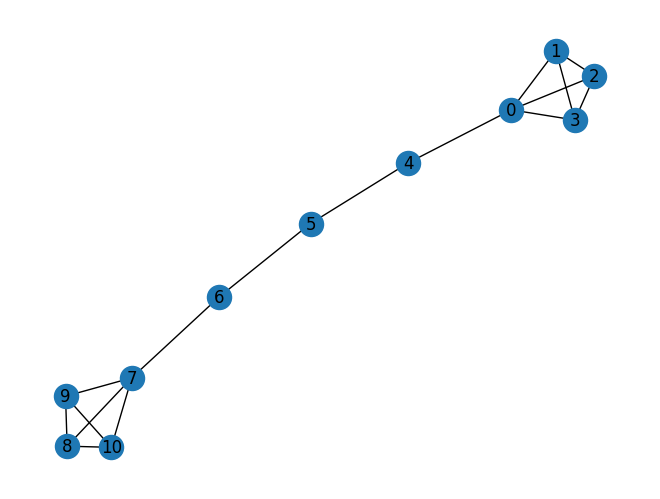

In [ ]:
nodes = [0,1,2,3,4,5,6,7,8,9,10]
edges = [(0,1),(0,4),(1,2),(2,3),(1,3),(3,0),(0,2),(4,5),(5,6),(6,7),(10,8),(10,9),(8,9),(8,7),(9,7),(7,10)]
graph=nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
nx.draw(graph,  with_labels=True)

Clusters : [0 0 0 0 1 1 1 2 2 2 2]
Best Chromosom : [ 3  2  1  1  5  6  5  9 10  8  7]
Fitness score : 0.509765625


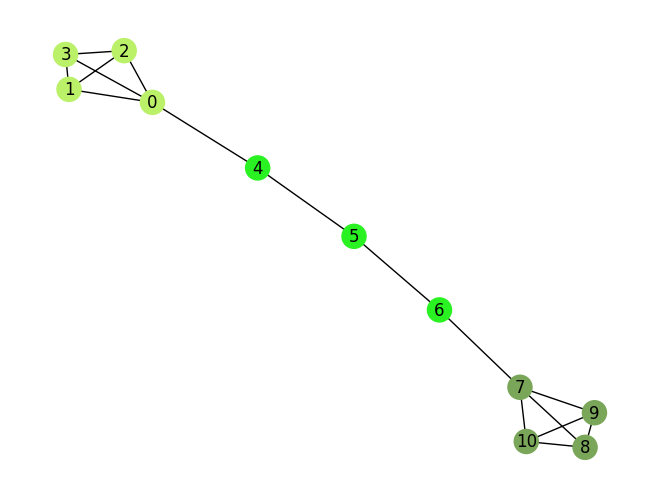

In [ ]:
GA_CD(graph, 5, 6)

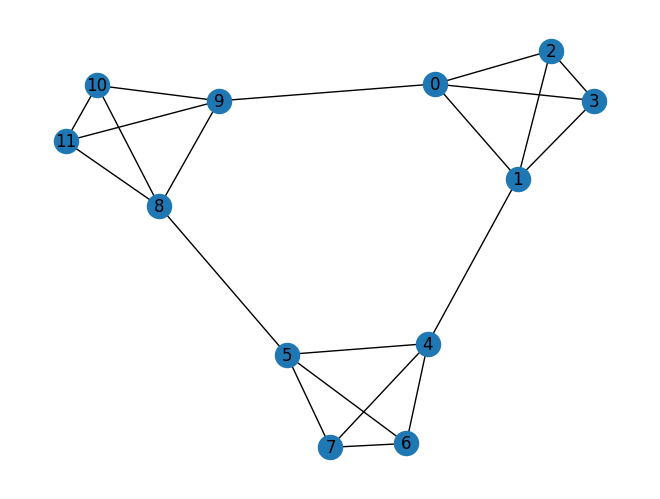

In [ ]:
graph=nx.ring_of_cliques(3,4)
nx.draw(graph,  with_labels=True)
G = nx.to_numpy_array(graph).astype(int)

Clusters : [0 0 0 0 1 1 1 1 2 2 2 2]
Best Chromosom : [ 3  0  3  2  7  6  7  5  9 10  9 10]
Fitness score : 0.5238095238095237


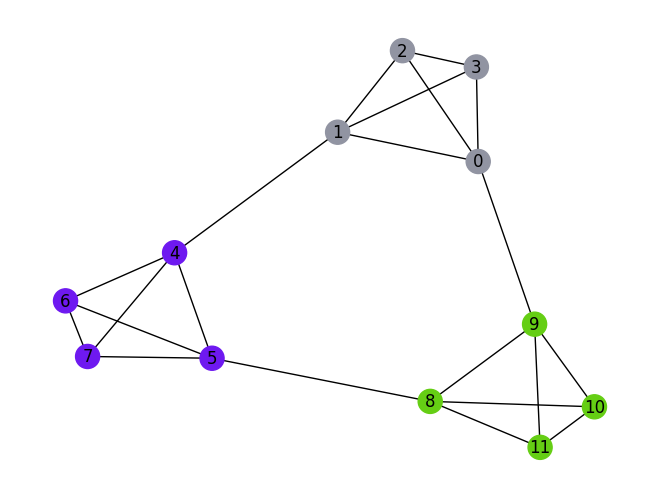

In [ ]:
GA_CD(graph, 5, 6)

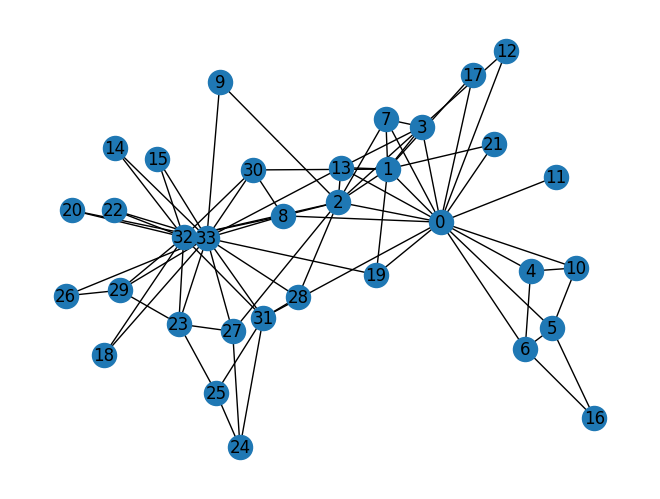

In [ ]:
graph= nx.karate_club_graph()
nx.draw(graph,with_labels=True)

Clusters : [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 2 1 1 2 1 1 1 1]
Best Chromosom : [ 2 19  3 12  0  0  5  0 32  2  4  0  3  2 32 32  5  0 33  0 33  0 33 25
 27 23 29 23 33 26  8 24 20 23]
Fitness score : 2.0611439842209074


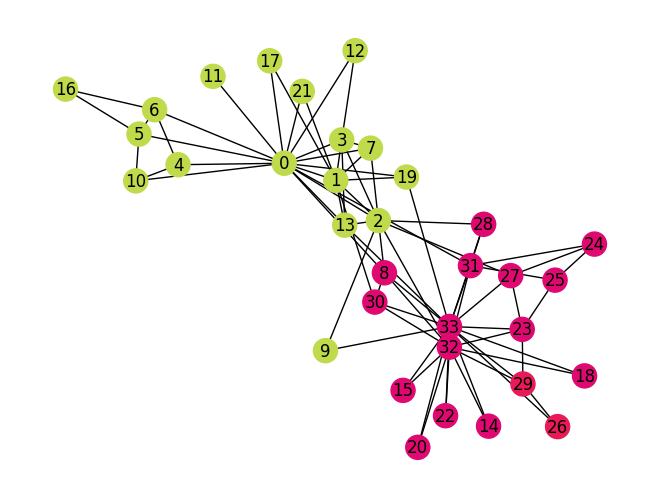

In [ ]:
GA_CD(graph, 5, 6)

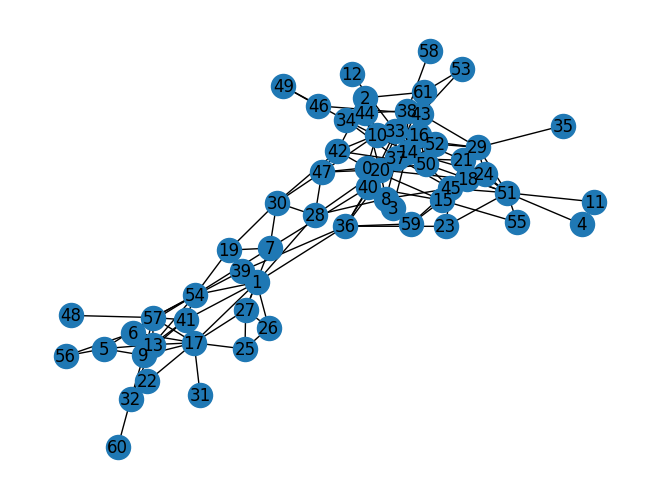

In [ ]:
graph = nx.read_gml("dolphins.gml")

nx.draw(graph, with_labels=True)

Clusters : [0 0 1 1 1 1 0 0 0 0 0 0 0 1 2 0 1 3 1 1 1 1 1 1 2 2 2 2 2 2 0 0 3 1 1 2 1
 1 1 1 1 1 4 1 1 1 1 1 1 0 0 0 1 1 1 2 4 2 1 1 1 2]
Best Chromosom : [ 6  0 44 34  3 45 12 11 11 31 50 30  7 21 28 30  5 32 16 20 33 19 23 48
 25 29 14 24 25 27 31  9 17 18 33 26 52 23 39 45 45  2 56 44  2  2 36 23
  3  8 11  8 33 23 36 35 42 28 43 44 18 28]
Fitness score : 0.37985048059807763


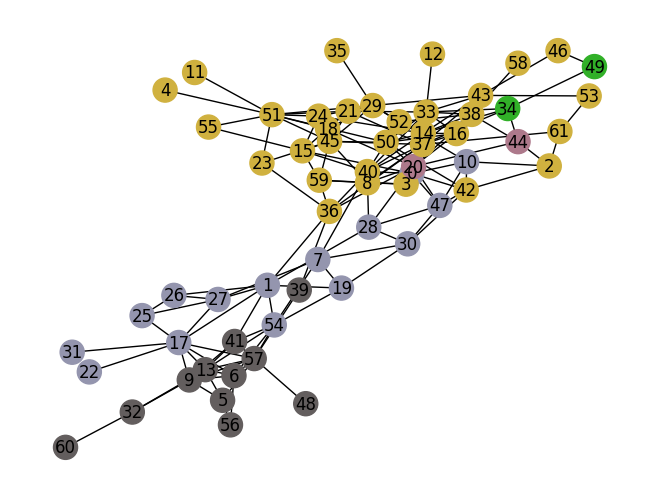

In [ ]:
GA_CD(graph, 5, 6)